### Import Libraries


In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

import sys

sys.path.append("../utils")
from validate_utils import create_classification_profiles

### Load Cell Health Profile Labels


In [2]:
cell_health_hash = "30ea5de393eb9cfc10b575582aa9f0f857b44c59"
cell_health_labels_link = f"https://raw.github.com/broadinstitute/cell-health/{cell_health_hash}/1.generate-profiles/data/consensus/cell_health_median.tsv.gz"

cell_health_labels = pd.read_csv(cell_health_labels_link, compression="gzip", sep="\t")
cell_health_labels


,Metadata_profile_id,Metadata_pert_name,Metadata_cell_line,cc_all_high_h2ax,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_h2ax_mean,cc_all_n_spots_h2ax_per_nucleus_area_mean,cc_all_nucleus_area_mean,...,vb_num_live_cells,vb_percent_all_apoptosis,vb_percent_caspase_dead_only,vb_percent_dead,vb_percent_dead_only,vb_percent_early_apoptosis,vb_percent_late_apoptosis,vb_percent_live,vb_ros_back_mean,vb_ros_mean
0,profile_0,AKT1-1,A549,0.008156,0.587977,0.018820,0.381501,0.176564,0.187675,-0.170616,...,0.399842,0.000000,-0.118976,-0.132871,-0.121090,0.000000,0.000000,0.132882,0.806970,1.293984
1,profile_1,AKT1-2,A549,0.056667,1.264627,0.241450,0.568443,0.235304,0.372684,-0.276888,...,0.101670,0.318027,0.621374,0.100032,0.074036,0.132751,0.467027,-0.099917,0.558041,1.151867
2,profile_2,ARID1B-1,A549,0.111163,1.092964,0.151393,0.290203,0.402121,0.481700,-0.276980,...,0.080701,0.339100,0.598093,0.055951,0.042014,0.165161,0.247058,-0.055920,-0.393937,0.103202
3,profile_3,ARID1B-2,A549,-0.061528,0.320829,-0.091007,0.141819,-0.378769,-0.288693,-0.108741,...,0.265754,0.098699,0.371930,-0.063935,-0.055160,0.138654,0.000000,0.063946,0.210005,0.055291
4,profile_4,ATF4-1,A549,3.967818,0.003400,3.268615,-2.246887,2.891737,2.878938,2.853995,...,-2.343919,0.000000,-0.089544,0.141535,0.131393,0.000000,0.000000,-0.141397,-0.631390,0.106477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,profile_352,TXN-2,HCC44,-0.342210,0.215623,0.375192,0.900283,-0.116349,-0.083793,0.207844,...,1.568620,-0.409888,0.148385,-0.519448,-0.372714,-0.136141,-0.502358,0.520090,0.182738,-0.116806
353,profile_353,XBP-1,HCC44,-0.247848,0.564827,-0.422787,0.780852,-0.074603,0.000000,-0.123090,...,0.344139,0.172909,0.839550,-0.212904,-0.245979,0.417994,0.028582,0.213691,0.245257,0.105633
354,profile_354,XBP-2,HCC44,-0.349572,-0.303116,-0.458782,0.434831,-0.157653,-0.058808,-0.404611,...,1.341318,-0.069684,0.540557,-0.146842,-0.288259,-0.179506,0.047976,0.147173,0.744648,0.023499
355,profile_355,YAP1-1,HCC44,-0.240422,0.408734,-0.351545,0.387100,-0.132059,0.002797,-0.059520,...,0.091803,-0.155056,-0.025451,-0.097891,-0.080691,-0.227172,-0.114292,0.098480,0.451868,0.127519


### Create Classification Profiles


In [3]:
cell_line_plates = {
    "A549": ["SQ00014610", "SQ00014611", "SQ00014612"],
    "ES2": ["SQ00014613", "SQ00014614", "SQ00014615"],
    "HCC44": ["SQ00014616", "SQ00014617", "SQ00014618"],
}


In [4]:
cell_health_plate_classifications = pathlib.Path(
    "/media/roshankern/63af2010-c376-459e-a56e-576b170133b6/data/cell-health-plate-classifications"
)
MCM_classifications = pathlib.Path(
    f"{cell_health_plate_classifications}/multi_class_models"
)
SCM_classifications = pathlib.Path(
    f"{cell_health_plate_classifications}/single_class_models"
)

classification_profiles_save_dir = pathlib.Path(
    "/media/roshankern/63af2010-c376-459e-a56e-576b170133b6/data/cell-health-plate-classification-profiles"
)
classification_profiles_save_dir.mkdir(exist_ok=True, parents=True)

print("Deriving multi class model classification profiles")
for model_classifications_dir in MCM_classifications.iterdir():

    # get information about the current model's classifications we are looking at
    model_type = model_classifications_dir.name.split("__")[0]
    feature_type = model_classifications_dir.name.split("__")[1].replace(".joblib", "")

    print(
        f"Deriving classification profiles for {model_type} model with {feature_type} features"
    )

    # derive classification profiles
    classification_profiles = create_classification_profiles(
        model_classifications_dir, cell_line_plates
    )

    # save classification profiles
    classification_profiles_save_path = pathlib.Path(
        f"{classification_profiles_save_dir}/multi_class_models/{model_classifications_dir.name}__classification_profiles.tsv"
    )
    classification_profiles_save_path.parent.mkdir(exist_ok=True, parents=True)
    classification_profiles.to_csv(classification_profiles_save_path, sep="\t", index=False)

print("Deriving single class model classification profiles")
for phenotypic_class_dir in SCM_classifications.iterdir():
    print(f"Deriving classification profiles for {phenotypic_class_dir.name} models")
    for model_classifications_dir in phenotypic_class_dir.iterdir():

        # get information about the current model
        phenotypic_class = phenotypic_class_dir.name.split("_")[0]
        model_type = model_classifications_dir.name.split("__")[0]
        feature_type = model_classifications_dir.name.split("__")[1].replace(".joblib", "")

        print(
            f"Deriving classification profiles for {model_type} model with {feature_type} features"
        )

        # derive classification profiles
        classification_profiles = create_classification_profiles(
            model_classifications_dir, cell_line_plates
        )

        # save classification profiles
        classification_profiles_save_path = pathlib.Path(
            f"{classification_profiles_save_dir}/single_class_models/{phenotypic_class}/{model_classifications_dir.name}__classification_profiles.tsv"
        )
        classification_profiles_save_path.parent.mkdir(exist_ok=True, parents=True)
        classification_profiles.to_csv(classification_profiles_save_path, sep="\t", index=False)

Deriving multi class model classification profiles
Deriving classification profiles for shuffled_baseline model with CP features
Deriving single class model classification profiles
Deriving classification profiles for MetaphaseAlignment_models models
Deriving classification profiles for shuffled_baseline model with CP features


,Metadata_pert_name,Metadata_cell_line,MetaphaseAlignment,MetaphaseAlignment Negative
0,AKT1-1,A549,0.529641,0.470359
1,AKT1-2,A549,0.529872,0.470128
2,ARID1B-1,A549,0.529799,0.470201
3,ARID1B-2,A549,0.530574,0.469426
4,ATF4-1,A549,0.533062,0.466938
...,...,...,...,...
352,XBP-1,HCC44,0.529994,0.470006
353,XBP-2,HCC44,0.529618,0.470382
354,YAP1-1,HCC44,0.534580,0.465420
355,YAP1-2,HCC44,0.531002,0.468998


In [ ]:
cell_health_data_hash = "4ee08b16f4b5c5266309a295b0a1697f0b9540b8"
plate_classifications_dir_link = f"https://github.com/WayScience/cell-health-data/raw/{cell_health_data_hash}/4.classify-features/plate_classifications"
cell_line_plates = {
    "A549": ["SQ00014610", "SQ00014611", "SQ00014612"],
    "ES2": ["SQ00014613", "SQ00014614", "SQ00014615"],
    "HCC44": ["SQ00014616", "SQ00014617", "SQ00014618"],
}

classification_profiles = create_classification_profiles(
    plate_classifications_dir_link, cell_line_plates
)
classification_profiles

,Metadata_pert_name,Metadata_cell_line,ADCCM,Anaphase,Apoptosis,Artefact,Binuclear,Elongated,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,OutOfFocus,Polylobed,Prometaphase,SmallIrregular
0,AKT1-1,A549,0.054932,0.027755,0.021307,0.048169,0.116542,0.027095,0.040155,0.030093,0.221322,0.019687,0.040099,0.037670,0.098610,0.129647,0.041857,0.045061
1,AKT1-2,A549,0.052757,0.026695,0.022417,0.047275,0.113333,0.026610,0.041179,0.034239,0.233669,0.021312,0.039802,0.036686,0.089843,0.128045,0.041199,0.044936
2,ARID1B-1,A549,0.040267,0.028365,0.021202,0.047656,0.119522,0.024333,0.039460,0.035141,0.290153,0.028437,0.035434,0.040248,0.044184,0.136870,0.033468,0.035259
3,ARID1B-2,A549,0.045109,0.030562,0.021584,0.041333,0.123428,0.027050,0.039057,0.028491,0.293695,0.026684,0.033261,0.043536,0.045784,0.124731,0.036990,0.038706
4,ATF4-1,A549,0.026970,0.035827,0.016918,0.013856,0.090874,0.028103,0.019467,0.016642,0.508466,0.039001,0.016502,0.052635,0.012241,0.061432,0.035789,0.025276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,XBP-1,HCC44,0.032277,0.027736,0.029891,0.053386,0.107091,0.041403,0.038645,0.041323,0.282075,0.041348,0.033903,0.048170,0.044153,0.108327,0.035608,0.034663
353,XBP-2,HCC44,0.032669,0.029002,0.031823,0.054948,0.106691,0.039883,0.036857,0.046972,0.265102,0.041838,0.035828,0.047439,0.045634,0.112850,0.035914,0.036549
354,YAP1-1,HCC44,0.034511,0.027847,0.037634,0.050009,0.087623,0.043881,0.047348,0.056616,0.191724,0.036977,0.032514,0.039765,0.137421,0.088149,0.047577,0.040405
355,YAP1-2,HCC44,0.033771,0.028334,0.030037,0.056260,0.105229,0.038985,0.033854,0.043182,0.256354,0.042508,0.036015,0.045088,0.074877,0.092741,0.042136,0.040629


In [ ]:
# combine cell health label profiles and classification profiles on perturbation and cell line
final_profile_dataframe = pd.merge(
    cell_health_labels,
    classification_profiles,
    on=["Metadata_pert_name", "Metadata_cell_line"],
)
final_profile_dataframe

,Metadata_profile_id,Metadata_pert_name,Metadata_cell_line,cc_all_high_h2ax,cc_all_large_notround_polynuclear_mean,cc_all_large_round_polyploid_mean,cc_all_n_objects,cc_all_n_spots_h2ax_mean,cc_all_n_spots_h2ax_per_nucleus_area_mean,cc_all_nucleus_area_mean,...,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,OutOfFocus,Polylobed,Prometaphase,SmallIrregular
0,profile_0,AKT1-1,A549,0.008156,0.587977,0.018820,0.381501,0.176564,0.187675,-0.170616,...,0.040155,0.030093,0.221322,0.019687,0.040099,0.037670,0.098610,0.129647,0.041857,0.045061
1,profile_1,AKT1-2,A549,0.056667,1.264627,0.241450,0.568443,0.235304,0.372684,-0.276888,...,0.041179,0.034239,0.233669,0.021312,0.039802,0.036686,0.089843,0.128045,0.041199,0.044936
2,profile_2,ARID1B-1,A549,0.111163,1.092964,0.151393,0.290203,0.402121,0.481700,-0.276980,...,0.039460,0.035141,0.290153,0.028437,0.035434,0.040248,0.044184,0.136870,0.033468,0.035259
3,profile_3,ARID1B-2,A549,-0.061528,0.320829,-0.091007,0.141819,-0.378769,-0.288693,-0.108741,...,0.039057,0.028491,0.293695,0.026684,0.033261,0.043536,0.045784,0.124731,0.036990,0.038706
4,profile_4,ATF4-1,A549,3.967818,0.003400,3.268615,-2.246887,2.891737,2.878938,2.853995,...,0.019467,0.016642,0.508466,0.039001,0.016502,0.052635,0.012241,0.061432,0.035789,0.025276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,profile_352,TXN-2,HCC44,-0.342210,0.215623,0.375192,0.900283,-0.116349,-0.083793,0.207844,...,0.042297,0.045487,0.242511,0.044597,0.034945,0.048240,0.061386,0.106988,0.041195,0.040591
353,profile_353,XBP-1,HCC44,-0.247848,0.564827,-0.422787,0.780852,-0.074603,0.000000,-0.123090,...,0.038645,0.041323,0.282075,0.041348,0.033903,0.048170,0.044153,0.108327,0.035608,0.034663
354,profile_354,XBP-2,HCC44,-0.349572,-0.303116,-0.458782,0.434831,-0.157653,-0.058808,-0.404611,...,0.036857,0.046972,0.265102,0.041838,0.035828,0.047439,0.045634,0.112850,0.035914,0.036549
355,profile_355,YAP1-1,HCC44,-0.240422,0.408734,-0.351545,0.387100,-0.132059,0.002797,-0.059520,...,0.047348,0.056616,0.191724,0.036977,0.032514,0.039765,0.137421,0.088149,0.047577,0.040405


Correlations for cell line A549
Correlations for cell line ES2
Correlations for cell line HCC44


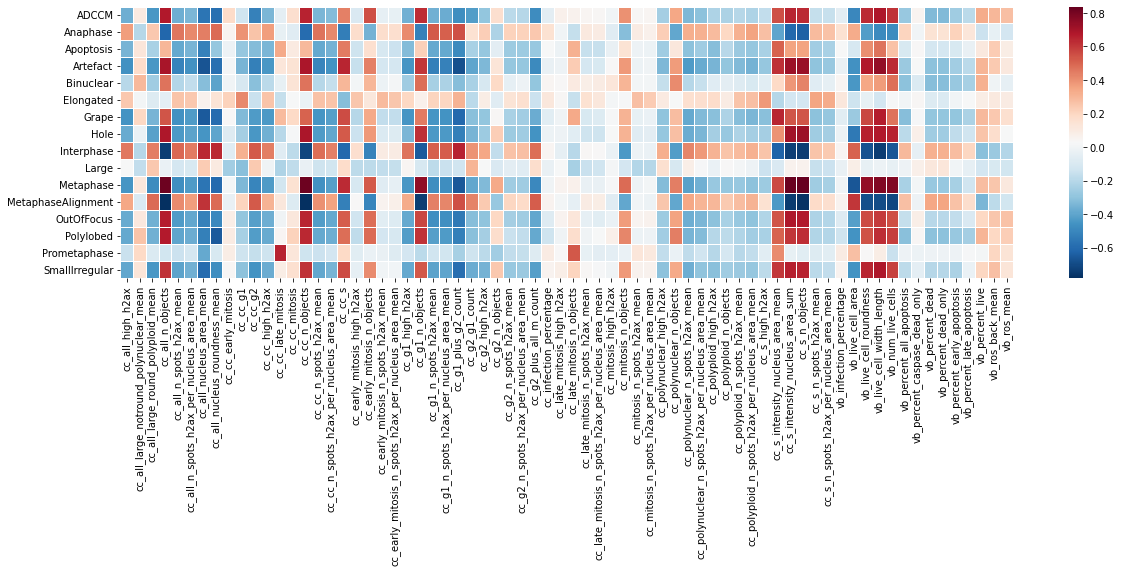

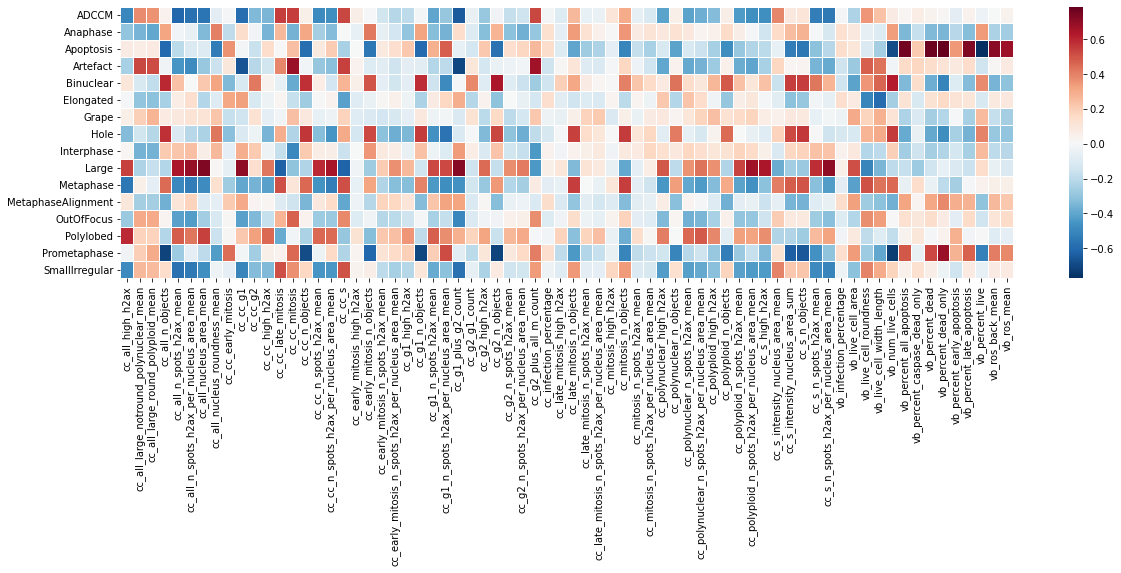

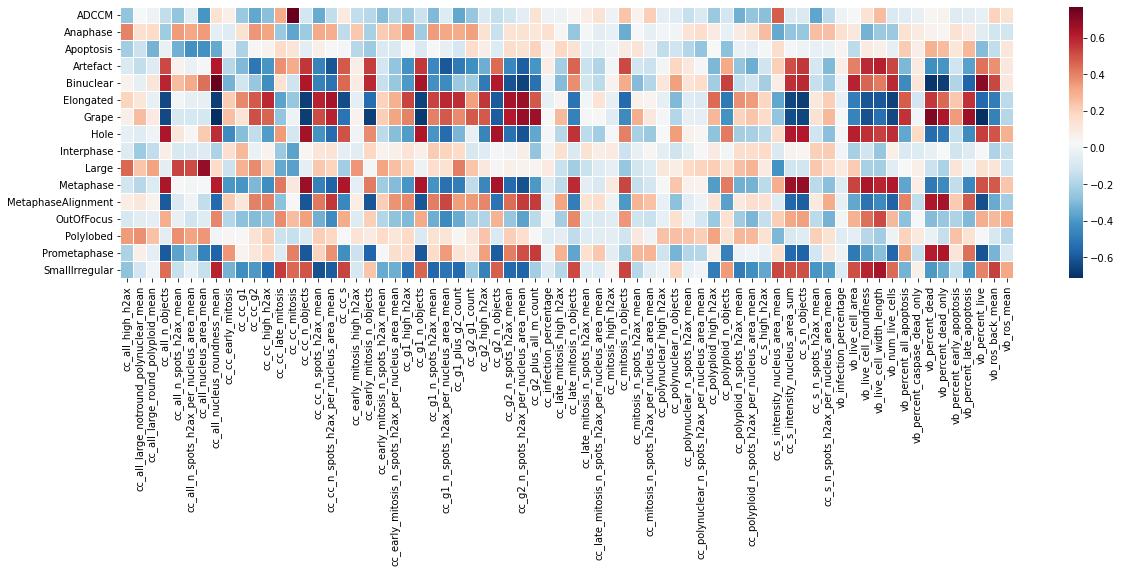

In [ ]:
for cell_line in final_profile_dataframe["Metadata_cell_line"].unique():
    print(f"Correlations for cell line {cell_line}")

    cell_line_profiles = final_profile_dataframe.loc[
        final_profile_dataframe["Metadata_cell_line"] == cell_line
    ]

    corr = cell_line_profiles.corr(method="pearson")
    # convert correlation to diagram-friendly format
    corr_graph = corr.iloc[70:, :70]

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(
        corr_graph,
        xticklabels=corr_graph.columns,
        yticklabels=corr_graph.index,
        cmap="RdBu_r",
        linewidth=0.5,
        ax=ax,
    )

### Find Correlation


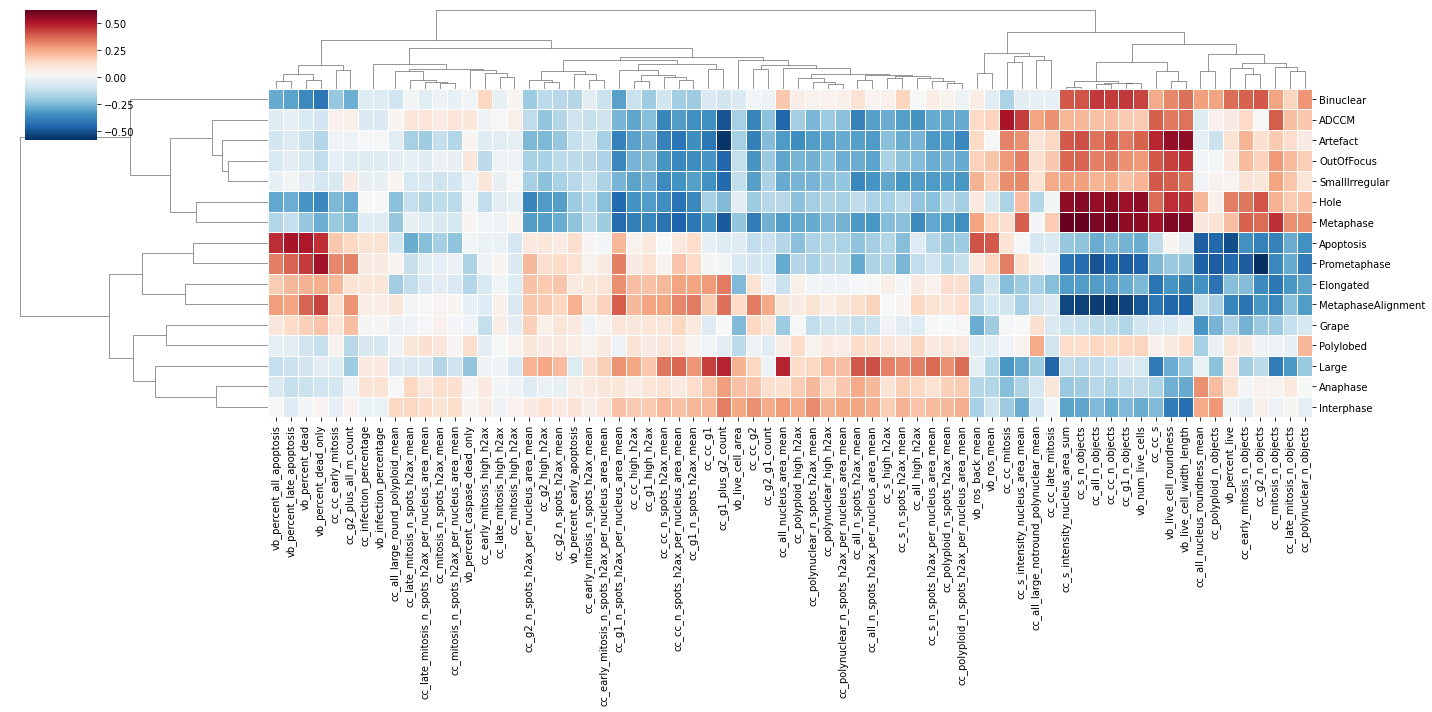

In [ ]:
correlation_method = "pearson"

# combine cell health label profiles and classification profiles on perturbation and cell line
final_profile_dataframe = pd.merge(
    cell_health_labels,
    classification_profiles,
    on=["Metadata_pert_name", "Metadata_cell_line"],
)
# find correlation
corr = final_profile_dataframe.corr(method=correlation_method)
# convert correlation to diagram-friendly format
corr_graph = corr.iloc[70:, :70]
corr_graph

### Show Correlation with Clustermap


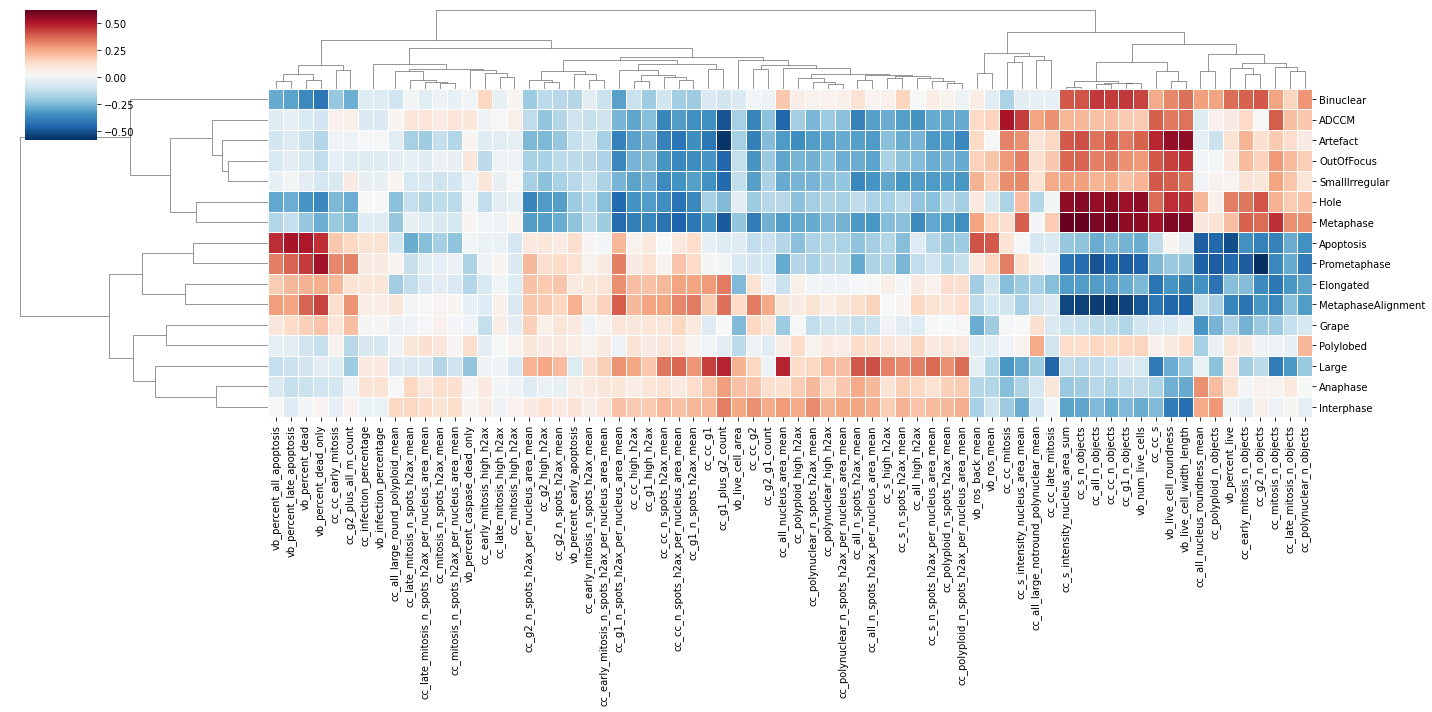

In [ ]:
sns.clustermap(
    corr_graph,
    xticklabels=corr_graph.columns,
    yticklabels=corr_graph.index,
    cmap="RdBu_r",
    linewidth=0.5,
    figsize=(20, 10),
)

### Save Correlation Data in Tidy Long Format


In [ ]:
corr_data_save_path = pathlib.Path(
    f"validations/cell_health_{correlation_method}_correlations.tsv"
)
corr_data_save_path.parents[0].mkdir(parents=True, exist_ok=True)

tidy_data = corr_graph.stack()
tidy_data = pd.DataFrame(tidy_data).reset_index(level=[0, 1])
tidy_data.columns = ["Phenotypic_Class", "Cell_Health_Label", "Correlation"]

tidy_data.to_csv(corr_data_save_path, sep="\t")
tidy_data

,Phenotypic_Class,Cell_Health_Label,Correlation
0,ADCCM,cc_all_high_h2ax,-0.335601
1,ADCCM,cc_all_large_notround_polynuclear_mean,0.264333
2,ADCCM,cc_all_large_round_polyploid_mean,0.032539
3,ADCCM,cc_all_n_objects,0.200643
4,ADCCM,cc_all_n_spots_h2ax_mean,-0.381297
...,...,...,...
1115,SmallIrregular,vb_percent_early_apoptosis,-0.141242
1116,SmallIrregular,vb_percent_late_apoptosis,0.006818
1117,SmallIrregular,vb_percent_live,0.037855
1118,SmallIrregular,vb_ros_back_mean,0.232665
